In [1]:
!python -V

Python 3.9.12


In [2]:
import pandas as pd


In [3]:
import pickle


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [6]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [7]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.838799799829435

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


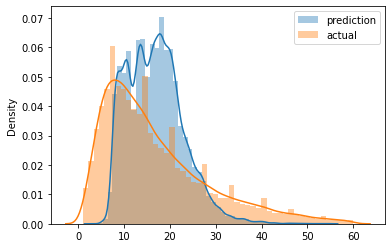

In [8]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [9]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [10]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [11]:
len(df_train), len(df_val)

(73908, 61921)

In [12]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [13]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [14]:
X_val.shape

(61921, 13221)

In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.75871520559622

In [17]:
with open('./models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [18]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.167275941179728

## Home work

The below function is just created but not used anywhere 

In [19]:
def read_hw_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.dropOff_datetime = pd.to_datetime(df.dropOff_datetime)
        df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PUlocationID', 'DOlocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [20]:
df_hw_train=pd.read_parquet('./data/fhv_tripdata_2021-01.parquet')
df_hw_val=pd.read_parquet('./data/fhv_tripdata_2021-02.parquet')

Q1. Number of rows in January data

In [21]:
df_hw_train.shape

(1154112, 7)

In [22]:
df_hw_train.columns

Index(['dispatching_base_num', 'pickup_datetime', 'dropOff_datetime',
       'PUlocationID', 'DOlocationID', 'SR_Flag', 'Affiliated_base_number'],
      dtype='object')

In [23]:
import numpy as np
df_hw_train['duration'] = df_hw_train.dropOff_datetime - df_hw_train.pickup_datetime
df_hw_train.duration = df_hw_train.duration.apply(lambda td: td.total_seconds() / 60)
print('Before cleaning the outliers',np.mean(df_hw_train.duration))

df_hw_train = df_hw_train[(df_hw_train.duration >= 1) & (df_hw_train.duration <= 60)]

print('After cleaning the outliers',np.mean(df_hw_train.duration))


Before cleaning the outliers 19.1672240937939
After cleaning the outliers 16.247253368247375


In [24]:
print(len(df_hw_train))

1109826


In [25]:
print('How many rows are dropped? ', 1154112-1109826)

How many rows are dropped?  44286


In [26]:
df_hw_train['PUlocationID']=df_hw_train['PUlocationID'].fillna(-1)

In [27]:
df_hw_train['DOlocationID']=df_hw_train['DOlocationID'].fillna(-1)

In [28]:
count = (df_hw_train['PUlocationID'] == -1).sum()
count

927008

In [29]:
print('Ratio of filled -1 is ', 927008/1109826)

Ratio of filled -1 is  0.8352732770722617


In [30]:
categorical = ['PUlocationID', 'DOlocationID']
df_hw_train[categorical] = df_hw_train[categorical].astype(str)


In [31]:
train_dicts = df_hw_train[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
target = 'duration'
y_train = df_hw_train[target].values

print(X_train.shape,y_train.shape)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

(1109826, 525) (1109826,)


10.528519425310185

In [32]:
#df_hw_val=pd.read_parquet('./data/fhv_tripdata_2021-02.parquet')
df_hw_val['duration'] = df_hw_val.dropOff_datetime - df_hw_val.pickup_datetime
df_hw_val.duration = df_hw_val.duration.apply(lambda td: td.total_seconds() / 60)

df_hw_val = df_hw_val[(df_hw_val.duration >= 1) & (df_hw_val.duration <= 60)]

categorical = ['PUlocationID', 'DOlocationID']
df_hw_val[categorical] = df_hw_val[categorical].astype(str)

print(len(df_hw_val))

990113


In [33]:
df_hw_val['PUlocationID']=df_hw_val['PUlocationID'].fillna(-1)
df_hw_val['DOlocationID']=df_hw_val['DOlocationID'].fillna(-1)

In [34]:
val_dicts = df_hw_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [35]:
target = 'duration'
y_val = df_hw_val[target].values


In [36]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.364081705267695